<a href="https://colab.research.google.com/github/jamescavanagh/unpackAI/blob/main/EEG_Wavelet_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# initalize drive
from google.colab import drive
drive.mount('/content/drive')
!pip install -Uqq fastbook kaggle waterfallcharts treeinterpreter dtreeviz mne tslearn sktime
import fastbook
fastbook.setup_book()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
     |████████████████████████████████| 720 kB 5.2 MB/s 
     |████████████████████████████████| 60 kB 8.3 MB/s 
     |████████████████████████████████| 6.9 MB 29.1 MB/s 
     |████████████████████████████████| 793 kB 65.1 MB/s 
     |████████████████████████████████| 5.8 MB 75.8 MB/s 
     |████████████████████████████████| 186 kB 74.1 MB/s 
     |████████████████████████████████| 46 kB 4.5 MB/s 
     |████████████████████████████████| 1.2 MB 66.6 MB/s 
     |████████████████████████████████| 56 kB 4.3 MB/s 
     |████████████████████████████████| 51 kB 364 kB/s 
     |████████████████████████████████| 22.3 MB 1.1 MB/s 
     |████████████████████████████████| 9.5 MB 63.1 MB/s 
Mounted at /content/gdrive


In [3]:
drive.mount('/content/drive') # in case of remount


from fastbook import *
from fastai.vision.widgets import *
import os

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Imports


#Base Libraries  


import os
from multiprocessing import Pool
import itertools
import random 
import cv2


# Data Science Librarires

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

from google.colab.patches import cv2_imshow


# Heriarchical clustering

from sktime.distances.elastic_cython import dtw_distance
from scipy.cluster.hierarchy import single, complete, average, ward, dendrogram
from scipy.cluster.hierarchy import fcluster

# Wavelet Transform

import pywt



In [4]:
random.seed(42)

In [5]:
# Loading the data

# Multiprocessing increase the speed signiicantly from 5 minute


train_dir = '/content/drive/My Drive/Colab_Data/EEG/SMNI_CMI_TRAIN/Train/'

# wrap your csv importer in a function that can be mapped
def read_csv(filename):
    'converts a filename to a pandas dataframe'
    return pd.read_csv(filename)


# get a list of file names
files = os.listdir(train_dir)
file_list = [os.path.join(train_dir,filename) for filename in files if filename.split('.')[1]=='csv']
                     
print(file_list[0])

# set up your pool
with Pool(processes=8) as pool: # or whatever your hardware can support

    # have your pool map the file names to dataframes


    df_list = pool.map(read_csv, file_list)

    # reduce the list of dataframes to a single dataframe
    combined_df = pd.concat(df_list, ignore_index=True)

EEG_data = combined_df[combined_df['subject identifier'] == 'a']
EEG_data_control = combined_df[combined_df['subject identifier'] == 'c']

del combined_df

/content/drive/My Drive/Colab_Data/EEG/SMNI_CMI_TRAIN/Train/Data11.csv


# Data Cleansing and Wrangling


In [6]:
# Wrangling the sensor position capitalization

EEG_data = EEG_data.drop(['Unnamed: 0'], axis=1)
EEG_data.loc[EEG_data['matching condition'] == 'S2 nomatch,', 'matching condition'] =  'S2 nomatch' ## remove comma sign from stimulus name  

## replace some 'senso4/1AX4XfWjxIbaBk1mjB1EGwKxLgAcVGZ4jYKlCxUrTC3J6zb1GcEgabB3B9bMr position' values
EEG_data.loc[EEG_data['sensor position'] == 'AF1', 'sensor position'] = 'AF3'
EEG_data.loc[EEG_data['sensor position'] == 'AF2', 'sensor position'] = 'AF4'
EEG_data.loc[EEG_data['sensor position'] == 'PO1', 'sensor position'] = 'PO3'
EEG_data.loc[EEG_data['sensor position'] == 'PO2', 'sensor position'] = 'PO4'

EEG_data.loc[EEG_data['sensor position'] == 'FP1', 'sensor position'] = 'Fp1'
EEG_data.loc[EEG_data['sensor position'] == 'FP2', 'sensor position'] = 'Fp2'
EEG_data.loc[EEG_data['sensor position'] == 'CPZ', 'sensor position'] = 'CPz'
EEG_data.loc[EEG_data['sensor position'] == 'FZ', 'sensor position'] = 'Fz'

EEG_data.loc[EEG_data['sensor position'] == 'CZ', 'sensor position'] = 'Cz' ## exclusion of this position because it has a systematically extrem value

EEG_data.loc[EEG_data['sensor position'] == 'PZ', 'sensor position'] = 'Pz'
EEG_data.loc[EEG_data['sensor position'] == 'FPZ', 'sensor position'] = 'Fpz'
EEG_data.loc[EEG_data['sensor position'] == 'AFZ', 'sensor position'] = 'AFz'
EEG_data.loc[EEG_data['sensor position'] == 'FCZ', 'sensor position'] = 'FCz'

EEG_data.loc[EEG_data['sensor position'] == 'POZ', 'sensor position'] = 'POz'
EEG_data.loc[EEG_data['sensor position'] == 'OZ', 'sensor position'] = 'Oz'

## Control Group


EEG_data_control = EEG_data_control.drop(['Unnamed: 0'], axis=1) ## remove the unused column
EEG_data_control.loc[EEG_data_control['matching condition'] == 'S2 nomatch,', 'matching condition'] =  'S2 nomatch' ## remove comma sign from stimulus name    
## replace some 'sensor position' values
EEG_data_control.loc[EEG_data_control['sensor position'] == 'AF1', 'sensor position'] = 'AF3'
EEG_data_control.loc[EEG_data_control['sensor position'] == 'AF2', 'sensor position'] = 'AF4'
EEG_data_control.loc[EEG_data_control['sensor position'] == 'PO1', 'sensor position'] = 'PO3'
EEG_data_control.loc[EEG_data_control['sensor position'] == 'PO2', 'sensor position'] = 'PO4'

EEG_data_control.loc[EEG_data_control['sensor position'] == 'FP1', 'sensor position'] = 'Fp1'
EEG_data_control.loc[EEG_data_control['sensor position'] == 'FP2', 'sensor position'] = 'Fp2'
EEG_data_control.loc[EEG_data_control['sensor position'] == 'CPZ', 'sensor position'] = 'CPz'
EEG_data_control.loc[EEG_data_control['sensor position'] == 'FZ', 'sensor position'] = 'Fz'

EEG_data_control.loc[EEG_data_control['sensor position'] == 'CZ', 'sensor position'] = 'Cz' ## exclusion of this position because it has a systematically extrem value

EEG_data_control.loc[EEG_data_control['sensor position'] == 'PZ', 'sensor position'] = 'Pz'
EEG_data_control.loc[EEG_data_control['sensor position'] == 'FPZ', 'sensor position'] = 'Fpz'
EEG_data_control.loc[EEG_data_control['sensor position'] == 'AFZ', 'sensor position'] = 'AFz'
EEG_data_control.loc[EEG_data_control['sensor position'] == 'FCZ', 'sensor position'] = 'FCz'

EEG_data_control.loc[EEG_data_control['sensor position'] == 'POZ', 'sensor position'] = 'POz'
EEG_data_control.loc[EEG_data_control['sensor position'] == 'OZ', 'sensor position'] = 'Oz'

In [7]:
EEG_data.head(1) #shape x9 columns

,trial number,sensor position,sample num,sensor value,subject identifier,matching condition,channel,name,time
0,19,Fp1,0,-0.112,a,S2 nomatch,0,co2a0000364,0.0


In [8]:
# Organzing according to experiment condition groups

#Alc_Groups
Alc_S1Obj = EEG_data[EEG_data['matching condition'] == 'S1 obj']
Alc_S2Match = EEG_data[EEG_data['matching condition'] == 'S2 match']
Alc_S2Nomatch = EEG_data[EEG_data['matching condition'] == 'S2 nomatch']

#Control groups 
Con_S1Obj = EEG_data_control[EEG_data_control['matching condition'] == 'S1 obj']
Con_S2Match = EEG_data_control[EEG_data_control['matching condition'] == 'S2 match']
Con_S2Nomatch = EEG_data_control[EEG_data_control['matching condition'] == 'S2 nomatch']


def trial_len_integrity_check(inputDF):

  nameAndTrialNumber = inputDF.groupby(['trial number','name']).size().reset_index().rename(columns={0:'count'})
  nameAndTrialNumber['count'] =np.where(nameAndTrialNumber['count'] == 16384,False,True)

  del inputDF

  if nameAndTrialNumber['count'].any():
    # data integrity problem
    Exception('Data Integrity problem, one of the arrays is not shaped 256x256')
  #nameAndTrialNumber.drop(['count'],axis=1)

  return nameAndTrialNumber[['trial number','name']]


# Creating dataframes that contain relevant indexing information and checks data integrity
# Trial Number, and subject names 

Con_S1Obj_Index = trial_len_integrity_check(Con_S1Obj) 
Con_S2Match_Index = trial_len_integrity_check(Con_S2Match) 
Con_S2Nomatch_Index = trial_len_integrity_check(Con_S2Nomatch) 

Alc_S1Obj_Index = trial_len_integrity_check(Alc_S1Obj) 
Alc_S2Match_Index = trial_len_integrity_check(Alc_S2Match) 
Alc_S2Nomatch_Index = trial_len_integrity_check(Alc_S2Nomatch) 


In [9]:
#nameAndTrialNumber['count'] =np.where(nameAndTrialNumber['count'] != 16384,True,False)

# Processing the time series data into a wavelet


# Reasons: Seperate the frequency and time information

### wavelengths at lower hertz dominate the information that is in the waves at higher frequencies. 

# Steps

# Code to process the dataframe 

# Step 1, input the trial instance:

### Go through through each dictionary of trial information, and select the   

# Filter the dataframe 

# Step 2, analyse the trial, cluster the channels

# Step 3 Create a dictionary with the index information and the cluster which it belongs to

# Step 4 choose chose one from each cluster,then create a dictionary with the
# Cluster which it belongs to, then the index in the trial sample.



# Step 5  Take the dictionary, and use it to pull out one example of each cluster 


# Step 6 Render plot, and save it in memory as an np array, 


# Step 7, crop and filter the array


#Step 8 collage the arrays together


# Step 8 resize the collage, then save it to disk inside of a directory





# Step


In [10]:
# Step 1 Step 1, input the trial instance:

#Con_S1ObjTrials = trial_len_integrity_check(Con_S1Obj) 
#Con_S2MatchTrials = trial_len_integrity_check(Con_S2Match) 
#Con_S2NomatchTrials = trial_len_integrity_check(Con_S2Nomatch) 

#Alc_S1ObjTrials = trial_len_integrity_check(Alc_S1Obj) 
#Alc_S2MatchTrials = trial_len_integrity_check(Alc_S2Match) 
#Alc_S2NomatchTrials = trial_len_integrity_check(Alc_S2Nomatch) 




# stand in varialbes
input_data = Alc_S1Obj 
trial_index = Alc_S1Obj_Index
row = 0

#for row in trial_index.index:


#  one_second_frame = input_data[(input_data['trial number'] == trial_index.loc[row]['trial number']) &
#             (input_data['name'] == trial_index.loc[row]['name'])]
  #print(one_second_frame.shape) #should be 16384

def pull_one_second_frame(row, trial_index,input_data):

    """
    Indexes the dataframe for the unique name and trial,
    then creates a 64 by 256 pivot table
    containing the time, channel, and sensor voltage information

    """
    return input_data[(input_data['trial number'] == trial_index.loc[row]['trial number']) &
             (input_data['name'] == trial_index.loc[row]['name'])].pivot_table(index='channel', columns='time', values = 'sensor value')

In [11]:
One_Second_Frame = pull_one_second_frame(row,trial_index,input_data)

In [12]:
distance_matrix = One_Second_Frame

In [13]:
# Step 2 Analyse the second frames's 64 channels

# Variables
num_of_clusters = 14
distance_matrix = One_Second_Frame


def cluster_channels(distance_matrix,num_of_clusters):



  def hierarchical_clustering(dist_mat, method='ward'):
    if method == 'complete':
        Z = complete(distance_matrix)
    if method == 'single':
        Z = single(distance_matrix)
    if method == 'average':
        Z = average(distance_matrix)
    if method == 'ward':
        Z = ward(distance_matrix)

    # Plotted visualization

    #fig = plt.figure(figsize=(16, 8))
    #dn = dendrogram(Z)
    #plt.title(f"Dendrogram for {method}-linkage with correlation distance")
    #plt.show()

    return Z


  linkage_matrix = hierarchical_clustering(distance_matrix)

  # The cluster labels match the rows in the one second frame

  cluster_labels = fcluster(linkage_matrix, num_of_clusters, criterion='maxclust')

  #cluster_index = pd.concat([pd.Series(One_Second_Frame.index),pd.Series(cluster_labels)])

  return cluster_labels


In [14]:
print(One_Second_Frame.shape)

(64, 256)


In [15]:
# Step 3 create an index of the channels and the clusters

num_of_clusters = 14

cluster_index = cluster_channels(One_Second_Frame,num_of_clusters)

print('number of clusters')
print(cluster_index.shape)

unique_clusters = np.unique(cluster_index)
unique_clusters_count = np.unique(cluster_index,return_counts=True)[1]



number of clusters
(64,)


In [16]:
cluster_index

array([ 5,  5,  5, 11,  9,  9,  9,  9,  9,  9,  9,  9,  9, 10,  7, 14, 12,  3, 13,  3,  4,  4,  4,  4,  4,  4,  4,  2,  2,  2,  2,  5,  5,  6,  7,  9,  8, 10,  5,  9,  9,  4,  7,  9,  9,  4,  7,  9,
        4,  4,  4,  4,  9,  4,  1,  1,  9,  2,  2,  4,  4,  4,  5,  5], dtype=int32)

In [17]:
unique_clusters_count

array([ 2,  6,  2, 17,  8,  1,  4,  1, 17,  2,  1,  1,  1,  1])

# Step 4: Choosing the relevant frames

### Choose from the cluster in order to choose the one that is best

### Option one, correlate each channel to find the one that is the most like the other ones


### Option two: run another analysis in the clusters to choose the best one

### Option Three: Select from the 3rd one Choose a random one

## Choosing option three in order to create a baseline for further optimization



In [18]:
## Step 4: Choose the clusters to choose from

totalFramesToInclude = 9

# Include all the clusters that are larger than one
largerClusters = [k for k,v in enumerate(unique_clusters_count) if v > 1]
sizeOneClusters = list(set(unique_clusters).difference(largerClusters))


numToRandSelect = totalFramesToInclude - len(largerClusters)

random_small_clusters = random.sample(sizeOneClusters,numToRandSelect)

# Step 5
largerClusters.extend(random_small_clusters)

final_clusters = np.array(largerClusters)


if not totalFramesToInclude == len(final_clusters):
  Exception('total frames do not match')

#return clusters_to_use


In [19]:
#print(final_clusters)

In [20]:
# Step 5 take the final clusters then run through

#for num in final_clusters:
#  EEG_Frame = pull_one_second_frame() 

In [187]:


#Con_S1Obj_Index 
#Con_S2Match_Index 
#Con_S2Nomatch_Index 

#Alc_S1Obj_Index 
#Alc_S2Match_Index 
#Alc_S2Nomatch_Index 


In [21]:
# Functions

def cluster_channels(distance_matrix,num_of_clusters):

  def hierarchical_clustering(dist_mat, method='ward'):
    if method == 'complete':
        Z = complete(distance_matrix)
    if method == 'single':
        Z = single(distance_matrix)
    if method == 'average':
        Z = average(distance_matrix)
    if method == 'ward':
        Z = ward(distance_matrix)

    # Plotted visualization

    #fig = plt.figure(figsize=(16, 8))
    #dn = dendrogram(Z)
    #plt.title(f"Dendrogram for {method}-linkage with correlation distance")
    #plt.show()

    return Z

  linkage_matrix = hierarchical_clustering(distance_matrix)

  # The cluster labels match the rows in the one second frame

  cluster_labels = fcluster(linkage_matrix, num_of_clusters, criterion='maxclust')
  return cluster_labels

def select_clusters(cluster_index,totalFramesToInclude):
    
    unique_clusters = np.unique(cluster_index)
    unique_clusters_count = np.unique(cluster_index,return_counts=True)[1]
    #print(len(unique_clusters_count))
    unique_clusters_count[unique_clusters_count != 0]
    #print(len(unique_clusters_count))
    
    # Sort the order of the clusters into the largest to smallest

    unique , count = np.unique(cluster_index, return_counts=True)

    count_sort_ind = np.argsort(-count)

    size_sorted_clusters = unique[count_sort_ind]

  # Include all the clusters that are larger than one


    #largerClusters = [k for k,v in enumerate(unique_clusters_count) if v > 1]

    largerClusters = [k for k,v in enumerate(size_sorted_clusters) if v > 1]

    # Below is an extremely important line, removes a zero from the index 
    # that does not belong in the cluster index. Otherwise everything breaks

    largerClusters = [x for x in largerClusters if not x == 0]
  
    largerClusters = sorted(largerClusters)
    
    #print(len(largerClusters))
    
    #print(len(largerClusters))
    #print('larger clusters')
    #print(largerClusters)

    # If there are more 2+ size clusters than 9, then hanle that

    if len(largerClusters) == totalFramesToInclude:
      #largerClusters = sorted(largerClusters)

      #Sort by size
      final_clusters = largerClusters

    # If there are more, chose the larger clusters
    elif len(largerClusters) > totalFramesToInclude:
      largerClusters = sorted(largerClusters)
      #print('clusters > 9')
      #print(largerClusters)
  
      x = totalFramesToInclude
      #print(largerClusters)
      largerClusters = largerClusters[0:x]
      #print(len(largerClusters))

    elif len(largerClusters) < totalFramesToInclude: # Choose the larger clusters, and then randomly select size one clusters
      #print('shorter')
      sizeOneClusters = list(set(unique_clusters).difference(largerClusters))


      numToRandSelect = totalFramesToInclude - len(largerClusters)
      #print('should be this long')
      #print(str(numToRandSelect + len(largerClusters)))
      random_small_clusters = random.sample(sizeOneClusters,numToRandSelect)
      # Step 5
      #print(random_small_clusters)
      #print('smaller clusters')
      #print(random_small_clusters)
      largerClusters = largerClusters + random_small_clusters
      #print(len(largerClusters))
    else:
      Exception('size error')

    if not len(largerClusters) == totalFramesToInclude:
      print('not ok')
    
    #print(len(largerClusters))

    final_clusters = np.array(largerClusters)
    

    return final_clusters

# Step 5 1/2: select items from the cluster
def select_channels_to_transform(trial_index, clusters_index, final_clusters_index):
  
  """
  outputs indicies of the channels that will be called out of the
  64 Channel EEG frame

  Takes in a list of clusters that will be uses

  """
  
  finalChannelsIndex = {}

  #print(len(final_clusters_index))

  for i in np.nditer(final_clusters_index): #range(1,len(final_clusters_index)-1):
    #print(i)
    timeSeriesIndices = np.where(clusters_index==i)[0]
    if timeSeriesIndices.shape[0] == 0:
      print(len(timeSeriesIndices)) 

    randomSelectionIndex = np.random.choice(timeSeriesIndices)

    
    #print(randomSelectionIndex)
    finalChannelsIndex[randomSelectionIndex] = i
  
  return finalChannelsIndex




In [22]:
# Part 2 

# Conversion to Wavelet, Plotting, and Numpy conversion
def wavelet_transformation_plot_to_array(signal):
    dt = 0.25
    time = np.arange(0,256,1)
    scales = np.arange(1, 256)

  #def plot_wavelet(ax, time, signal, scales, waveletname = 'cmor', 
  #                 cmap = plt.cm.seismic, title = '', ylabel = '', xlabel = ''):
  

    def plot_wavelet(ax, time, signal, scales, waveletname = 'morl', 
                    cmap = plt.cm.seismic, title = '', ylabel = '', xlabel = ''):
        
        dt = time[1] - time[0]
        [coefficients, frequencies] = pywt.cwt(signal, scales, waveletname, dt)
        power = (abs(coefficients)) ** 2
        period = 1. / frequencies
        levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8]
        contourlevels = np.log2(levels)
        
        im = ax.contourf(time, np.log2(period), np.log2(power), contourlevels, extend='both',cmap=cmap)
        
        # turns off the plot
        plt.ioff()


        #ax.set_title(title, fontsize=20)
        #ax.set_ylabel(ylabel, fontsize=18)
        #ax.set_xlabel(xlabel, fontsize=18)
        
        yticks = 2**np.arange(np.ceil(np.log2(period.min())), np.ceil(np.log2(period.max())))
        ax.set_yticks(np.log2(yticks))
        ax.set_yticklabels(yticks)
        
        ax.invert_yaxis()
        ylim = ax.get_ylim()
        ax.set_ylim(ylim[0], -1)
        return yticks, ylim

    x = signal
    title = ''
    ylabel = ''
    xlabel = ''



    fig, ax = plt.subplots(figsize=(4,4))
    plt.ioff()
    plot_wavelet(ax, time, signal, scales, xlabel=xlabel, ylabel=ylabel, title=title)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.margins(x=0,y=0)
    plt.tight_layout(pad=0, rect=(0,0,0,0))

    def fig2data ( fig ):
        """
        @brief Convert a Matplotlib figure to a 4D numpy array with RGBA channels and return it
        @param fig a matplotlib figure
        @return a numpy 3D array of RGBA values
        """
        # draw the renderer
        fig.canvas.draw ( )
    
        # Get the RGBA buffer from the figure
        w,h = fig.canvas.get_width_height()
        buf = np.frombuffer ( fig.canvas.tostring_argb(), dtype=np.uint8 )
        buf.shape = ( w, h,4 )
    
        # canvas.tostring_argb give pixmap in ARGB mode. Roll the ALPHA channel to have it in RGBA mode
        buf = np.roll ( buf, 3, axis = 2 )
        return buf
    plt.close()
    outputArray = fig2data(fig)

    return outputArray

In [23]:
# part 3 array processing

def rgba2rgb( rgba, background=(255,255,255) ):
    row, col, ch = rgba.shape

    if ch == 3:
        return rgba

    assert ch == 4, 'RGBA image has 4 channels.'

    rgb = np.zeros( (row, col, 3), dtype='float32' )
    r, g, b, a = rgba[:,:,0], rgba[:,:,1], rgba[:,:,2], rgba[:,:,3]

    a = np.asarray( a, dtype='float32' ) / 255.0

    R, G, B = background

    rgb[:,:,0] = r * a + (1.0 - a) * R
    rgb[:,:,1] = g * a + (1.0 - a) * G
    rgb[:,:,2] = b * a + (1.0 - a) * B

    return np.asarray( rgb, dtype='uint8' )

#gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
# set filter values


#greyscale_array = np.dot(rgb_array[...,:3], [0.287,0.299, 0.814])


In [408]:
trial_index.loc[4]

trial number              0
name            co2a0000371
Name: 4, dtype: object

In [24]:
## Step 8: Collaging the images and saving them

# Function to name each image

def name_image(trial, trial_index,experiment_condition=''):
  """
  creates a file name for the image as a .jpg
  includes the trial number, subjectID, and the experiment condition

  OUTPUT = EXPCONDITION_TRIALNUMBER_SUBJECTID.jpg

  """

  trial_num = str(trial_index.loc[trial]['trial number'])
  subject_ID = str(trial_index.loc[trial]['name'])

  fileName = experiment_condition + '_' + trial_num + '_' + subject_ID + '.jpg' 

  return fileName

def name_image_a_or_c(trial, trial_index):
  """
  creates a file name for the image as a .jpg
  includes the trial number, subjectID, and the experiment condition

  OUTPUT = EXPCONDITION_TRIALNUMBER_SUBJECTID.jpg

  """

  trial_num = str(trial_index.loc[trial]['trial number'])
  subject_ID = str(trial_index.loc[trial]['name'])
  experiment_condition = str(trial_index.loc[trial]['trial info'])

  fileName = experiment_condition + '_' + trial_num + '_' + subject_ID + '.jpg' 

  return fileName


# Code to create the directories


# Function to save the image



In [428]:
# Code to create directories

#Base directory
!mkdir /home/james
!mkdir /home/james/EEG_Alc_Wavelets
root_dir = '/home/james/EEG_Alc_Wavelets'

#Alc and Con Group 
!mkdir /home/james/EEG_Alc_Wavelets/Con
!mkdir /home/james/EEG_AlcWaveletsAlc

#Alc Group 

#!mkdir /home/james/EEG_Alc_Wavelets/alc_s1Obj
#!mkdir /home/james/EEG_Alc_Wavelets/alc_s2Match
#!mkdir /home/james/EEG_Alc_Wavelets/alc_s2Nomatch

Alc_S1Obj_Dir = '/home/james/EEG_Alc_Wavelets/alc_s1Obj'
Alc_S2Match_Dir = '/home/james/EEG_Alc_Wavelets/alc_s2Match'
Alc_S2Nomatch_Dir = '/home/james/EEG_Alc_Wavelets/alc_s2Nomatch'

#Control Group

#!mkdir /home/james/EEG_Alc_Wavelets/con_s1Obj
#!mkdir /home/james/EEG_Alc_Wavelets/con_s2Match
#!mkdir /home/james/EEG_Alc_Wavelets/con_s2Nomatch

Con_S1Obj_Dir = '/home/james/EEG_Alc_Wavelets/con_s1Obj'
Con_S2Match_Dir = '/home/james/EEG_Alc_Wavelets/con_s2Match'
Con_S2Nomatch_Dir = '/home/james/EEG_Alc_Wavelets/con_s2Nomatch'

# For reference
"""

#Alc_Groups
Alc_S1Obj = EEG_data[EEG_data['matching condition'] == 'S1 obj']
Alc_S2Match = EEG_data[EEG_data['matching condition'] == 'S2 match']
Alc_S2Nomatch = EEG_data[EEG_data['matching condition'] == 'S2 nomatch']

#Control groups 
Con_S1Obj = EEG_data_control[EEG_data_control['matching condition'] == 'S1 obj']
Con_S2Match = EEG_data_control[EEG_data_control['matching condition'] == 'S2 match']
Con_S2Nomatch = EEG_data_control[EEG_data_control['matching condition'] == 'S2 nomatch']


Con_S1Obj_Index = trial_len_integrity_check(Con_S1Obj) 
Con_S2Match_Index = trial_len_integrity_check(Con_S2Match) 
Con_S2Nomatch_Index = trial_len_integrity_check(Con_S2Nomatch) 

Alc_S1Obj_Index = trial_len_integrity_check(Alc_S1Obj) 
Alc_S2Match_Index = trial_len_integrity_check(Alc_S2Match) 
Alc_S2Nomatch_Index = trial_len_integrity_check(Alc_S2Nomatch) 


"""


"\n\n#Alc_Groups\nAlc_S1Obj = EEG_data[EEG_data['matching condition'] == 'S1 obj']\nAlc_S2Match = EEG_data[EEG_data['matching condition'] == 'S2 match']\nAlc_S2Nomatch = EEG_data[EEG_data['matching condition'] == 'S2 nomatch']\n\n#Control groups \nCon_S1Obj = EEG_data_control[EEG_data_control['matching condition'] == 'S1 obj']\nCon_S2Match = EEG_data_control[EEG_data_control['matching condition'] == 'S2 match']\nCon_S2Nomatch = EEG_data_control[EEG_data_control['matching condition'] == 'S2 nomatch']\n\n"

In [443]:
!mkdir /home/james/EEG_Bin_Classifier
root_dir = '/home/james/EEG_Bin_Classifier'

!mkdir /home/james/EEG_Bin_Classifier/Alc
alc_dir = ' /home/james/EEG_Bin_Classifier/Alc'

!mkdir /home/james/EEG_Bin_Classifier/Con
con_dir = ' /home/james/EEG_Bin_Classifier/Con'

In [29]:
Alc_S1Obj_Index['trial info'] = 'a_S1Obj'
Alc_S2Match_Index['trial info'] = 'a_S2Match'
Alc_S2Nomatch_Index['trial info'] = 'a_S2Nomatch'

Con_S1Obj_Index['trial info'] = 'c_S1Obj'
Con_S2Match_Index['trial info'] = 'c_S2Match'
Con_S2Nomatch_Index['trial info'] = 'c_S2Nomatch'


In [30]:
All_Alcs = pd.concat([Alc_S1Obj_Index,Alc_S2Match_Index,Alc_S2Nomatch_Index])
All_Cons = pd.concat([Con_S1Obj_Index,Con_S2Match_Index,Con_S2Nomatch_Index])


In [31]:
All_Alcs.reset_index(drop=True,inplace=True)
All_Cons.reset_index(drop=True,inplace=True)

In [26]:
!mkdir '/content/drive/MyDrive/Colab_Data/DL201/EEG/Alc'
!mkdir '/content/drive/MyDrive/Colab_Data/DL201/EEG/Con'


# Code Execution

In [27]:
alc_wavelet_img_dir = '/content/drive/MyDrive/Colab_Data/DL201/EEG/Alc'
con_wavelet_img_dir = '/content/drive/MyDrive/Colab_Data/DL201/EEG/Con'

In [32]:
# Pulling it together

# Config varialbes
input_data = EEG_data
trial_index = All_Alcs
#experCond = 'c_S2Nomatch'
img_directory = alc_wavelet_img_dir


num_of_clusters = 14
totalFramesToInclude = 9 



for trial in trial_index.index: #runs through trial index
  #print('new row')
  EEG_Frame = pull_one_second_frame(trial,trial_index,input_data)

  # Analyse the EEG clusters
  cluster_labels = cluster_channels(EEG_Frame,num_of_clusters)

  final_clusters = select_clusters(cluster_labels,totalFramesToInclude)

  ########### Step 2 Selecting the channels for analysis

  final_channels = select_channels_to_transform(trial_index,cluster_labels,final_clusters)
  #print(final_channels)

  ########### Step 3 Processing the arrays

  array_dict = {}

  for key in final_channels.keys():
    #print(key)
    signal = EEG_Frame.loc[key]

    # Raw array representation of plots
    np_array = wavelet_transformation_plot_to_array(signal)
    plt.close()
    np_array = rgba2rgb(np_array)

    # Greyscale filter to decrease size of images

    np_array = np.dot(np_array[...,:3], [0.287,0.299, 0.814])

    array_dict[key] = np_array


  ############ Step 4 ### Creating a collage

  ordered_keys = list(array_dict.keys())

  for (k,v) in array_dict.items():
    array_dict[k] = cv2.resize(v,(200,200))


  horizontalRow1 = np.hstack([array_dict[ordered_keys[0]],array_dict[ordered_keys[1]],array_dict[ordered_keys[2]]])
  horizontalRow2 = np.hstack([array_dict[ordered_keys[3]],array_dict[ordered_keys[4]],array_dict[ordered_keys[5]]])
  horizontalRow3 = np.hstack([array_dict[ordered_keys[6]],array_dict[ordered_keys[7]],array_dict[ordered_keys[8]]])


  collaged_array = np.vstack([horizontalRow1,horizontalRow2,horizontalRow3])

  nameOfCollage = name_image_a_or_c(int(trial),trial_index)

  ######### Step 5 Save image

  filePath = os.path.join(img_directory,nameOfCollage)
  cv2.imwrite(filePath,collaged_array)

  




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.7/dist-packages/matplotlib/contour.py:1483: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/usr/local/lib/python3.7/dist-packages/matplotlib/contour.py:1484: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())


In [34]:
# Pulling it together

# Config varialbes
input_data = EEG_data_control
trial_index = All_Cons
#experCond = 'c_S2Nomatch'
img_directory = con_wavelet_img_dir


num_of_clusters = 14
totalFramesToInclude = 9 



for trial in trial_index.index: #runs through trial index
  #print('new row')
  EEG_Frame = pull_one_second_frame(trial,trial_index,input_data)

  # Analyse the EEG clusters
  cluster_labels = cluster_channels(EEG_Frame,num_of_clusters)

  final_clusters = select_clusters(cluster_labels,totalFramesToInclude)

  ########### Step 2 Selecting the channels for analysis

  final_channels = select_channels_to_transform(trial_index,cluster_labels,final_clusters)
  print(final_channels)

  ########### Step 3 Processing the arrays

  array_dict = {}

  for key in final_channels.keys():
    #print(key)
    signal = EEG_Frame.loc[key]

    # Raw array representation of plots# Config varialbes

    np_array = wavelet_transformation_plot_to_array(signal)
    np_array = rgba2rgb(np_array)

    # Greyscale filter to decrease size of images

    np_array = np.dot(np_array[...,:3], [0.287,0.299, 0.814])

    array_dict[key] = np_array


  ############ Step 4 ### Creating a collage

  ordered_keys = list(array_dict.keys())

  for (k,v) in array_dict.items():
    array_dict[k] = cv2.resize(v,(200,200))


  horizontalRow1 = np.hstack([array_dict[ordered_keys[0]],array_dict[ordered_keys[1]],array_dict[ordered_keys[2]]])
  horizontalRow2 = np.hstack([array_dict[ordered_keys[3]],array_dict[ordered_keys[4]],array_dict[ordered_keys[5]]])
  horizontalRow3 = np.hstack([array_dict[ordered_keys[6]],array_dict[ordered_keys[7]],array_dict[ordered_keys[8]]])


  collaged_array = np.vstack([horizontalRow1,horizontalRow2,horizontalRow3])

  nameOfCollage = name_image_a_or_c(int(trial),trial_index)

  ######### Step 5 Save image

  filePath = os.path.join(img_directory,nameOfCollage)
  cv2.imwrite(filePath,collaged_array)

  


{63: array(1), 7: array(2), 3: array(3), 60: array(4), 53: array(5), 55: array(7), 6: array(8), 17: array(9), 45: array(10)}
{35: array(1), 22: array(2), 55: array(3), 31: array(4), 63: array(5), 30: array(6), 47: array(7), 33: array(8), 7: array(10)}
{27: array(1), 36: array(2), 18: array(3), 20: array(5), 55: array(6), 31: array(7), 33: array(8), 3: array(9), 44: array(10)}
{11: array(1), 31: array(2), 10: array(3), 35: array(4), 47: array(5), 55: array(7), 26: array(8), 54: array(9), 14: array(10)}
{56: array(1), 53: array(2), 4: array(3), 54: array(5), 55: array(6), 63: array(7), 30: array(8), 25: array(9), 29: array(10)}
{15: array(1), 34: array(2), 55: array(3), 25: array(4), 30: array(5), 28: array(6), 41: array(7), 37: array(8), 56: array(9)}
{38: array(1), 4: array(2), 13: array(3), 36: array(4), 15: array(5), 16: array(6), 19: array(7), 56: array(8), 17: array(9)}
{33: array(1), 0: array(2), 12: array(3), 43: array(4), 55: array(5), 23: array(6), 39: array(7), 45: array(8), 9

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in log2


{5: array(1), 53: array(2), 8: array(4), 15: array(5), 3: array(6), 19: array(7), 12: array(8), 10: array(9), 26: array(10)}
{56: array(2), 37: array(3), 40: array(4), 41: array(5), 35: array(6), 63: array(7), 62: array(8), 26: array(9), 46: array(10)}
{24: array(1), 55: array(2), 58: array(3), 20: array(5), 45: array(6), 16: array(7), 49: array(8), 13: array(9), 47: array(10)}
{12: array(2), 32: array(3), 34: array(4), 33: array(5), 3: array(6), 60: array(7), 48: array(8), 59: array(9), 18: array(10)}
{57: array(1), 48: array(3), 54: array(4), 55: array(5), 46: array(6), 30: array(7), 62: array(8), 4: array(9), 34: array(10)}
{31: array(2), 42: array(3), 6: array(4), 8: array(5), 41: array(6), 2: array(7), 50: array(8), 25: array(9), 60: array(10)}
{38: array(1), 31: array(2), 60: array(4), 42: array(5), 63: array(6), 3: array(7), 6: array(8), 41: array(9), 9: array(10)}
{31: array(1), 15: array(2), 20: array(3), 43: array(4), 42: array(5), 2: array(6), 1: array(7), 33: array(8), 26: 

1        a_S1Obj
1      a_S2Match
1    a_S2Nomatch
Name: trial info, dtype: object

In [445]:
# copying the files


In [448]:
Alc_S1Obj_Dir = '/home/james/EEG_Alc_Wavelets/alc_s1Obj'
Alc_S2Match_Dir = '/home/james/EEG_Alc_Wavelets/alc_s2Match'
Alc_S2Nomatch_Dir = '/home/james/EEG_Alc_Wavelets/alc_s2Nomatch'

#Control Group

!mkdir /home/james/EEG_Alc_Wavelets/con_s1Obj
!mkdir /home/james/EEG_Alc_Wavelets/con_s2Match
!mkdir /home/james/EEG_Alc_Wavelets/con_s2Nomatch

Con_S1Obj_Dir = '/home/james/EEG_Alc_Wavelets/con_s1Obj'
Con_S2Match_Dir = '/home/james/EEG_Alc_Wavelets/con_s2Match'
Con_S2Nomatch_Dir = '/home/james/EEG_Alc_Wavelets/con_s2Nomatch'

# For reference

cp: cannot stat '/home/james/EEG_Alc_Wavelets/alc_S1Obj/*.jpg': No such file or directory


In [454]:
gdrivePath = '/content/drive/MyDrive/Colab_Data/EEG'

%cd '/content/drive/MyDrive/Colab_Data/EEG'


/content/drive/MyDrive/Colab_Data/EEG


In [455]:
!mkdir '/content/drive/MyDrive/Colab_Data/DL201/EEG'

!mkdir '/content/drive/MyDrive/Colab_Data/DL201/EEG/Alc'
!mkdir '/content/drive/MyDrive/Colab_Data/DL201/EEG/Con'



In [457]:
Alc_Dir = '/content/drive/MyDrive/Colab_Data/DL201/EEG/Alc'
Con_Dir = '/content/drive/MyDrive/Colab_Data/DL201/EEG/Con'


In [458]:
for fileName in os.listdir(Alc_S1Obj_Dir):
  shutil.copy(os.path.join(Alc_s1Obj_Dir,fileName), os.path.join(Alc_Dir,fileName))

In [461]:
!rm -r '/home/james/EEG_Alc_Wavelets/con_s2Match/.ipynb_checkpoints'

In [462]:
#for fileName in os.listdir(Alc_S2Match_Dir):
#  shutil.copy(os.path.join(Alc_S2Match_Dir,fileName), os.path.join(Alc_Dir,fileName))
#for fileName in os.listdir(Alc_S2Nomatch_Dir):
#  shutil.copy(os.path.join(Alc_S2Nomatch_Dir,fileName), os.path.join(Alc_Dir,fileName))

#for fileName in os.listdir(Con_S1Obj_Dir):
#  shutil.copy(os.path.join(Con_s1Obj_Dir,fileName), os.path.join(Con_Dir,fileName))
for fileName in os.listdir(Con_S2Match_Dir):
  shutil.copy(os.path.join(Con_S2Match_Dir,fileName), os.path.join(Con_Dir,fileName))
for fileName in os.listdir(Con_S2Nomatch_Dir):
  shutil.copy(os.path.join(Con_S2Nomatch_Dir,fileName), os.path.join(Con_Dir,fileName))


In [465]:
len(os.listdir(Con_Dir))

233

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:65: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


(288, 288, 3)
(288, 288, 3)
(288, 288, 3)
(288, 288, 3)
(288, 288, 3)
(288, 288, 3)
(288, 288, 3)
(288, 288, 3)
(288, 288, 3)


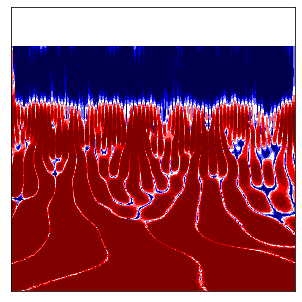

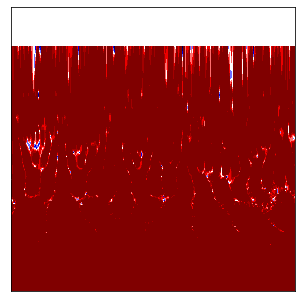

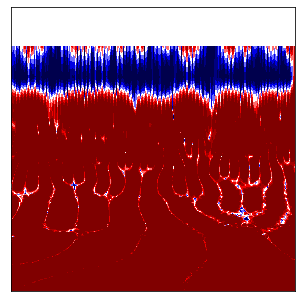

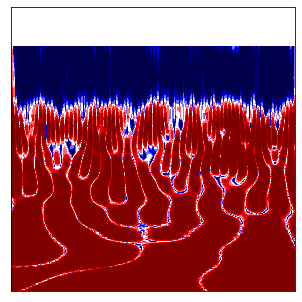

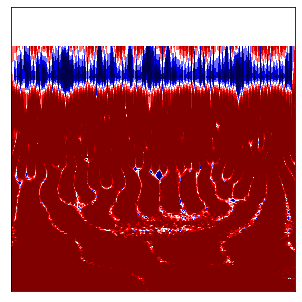

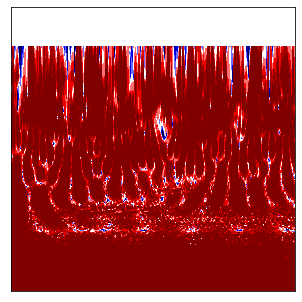

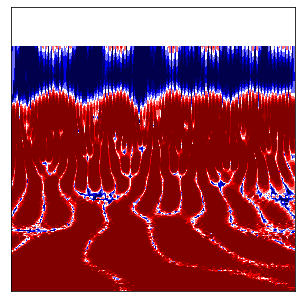

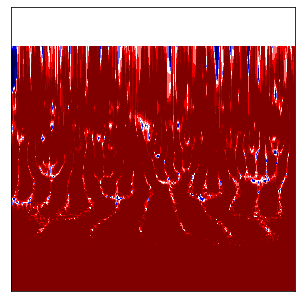

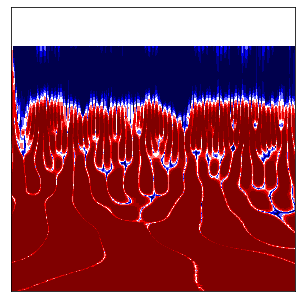

In [381]:
array_dict = {}

for key in final_channels.keys():
  signal = EEG_Frame.loc[key]
  raw_array = wavelet_transformation_plot_to_array(signal)

  rgb_array = rgba2rgb(raw_array)
  
  np_array = np.dot(rgb_array[...,:3], [0.287,0.299, 0.814])
  
  array_dict[key] = np_array
  print(rgb_array.shape)



In [359]:
len(array_dict)

9

In [372]:
ordered_keys = list(array_dict.keys())

In [374]:
len(ordered_keys)

9

In [384]:
collaged_array.shape

(600, 600)

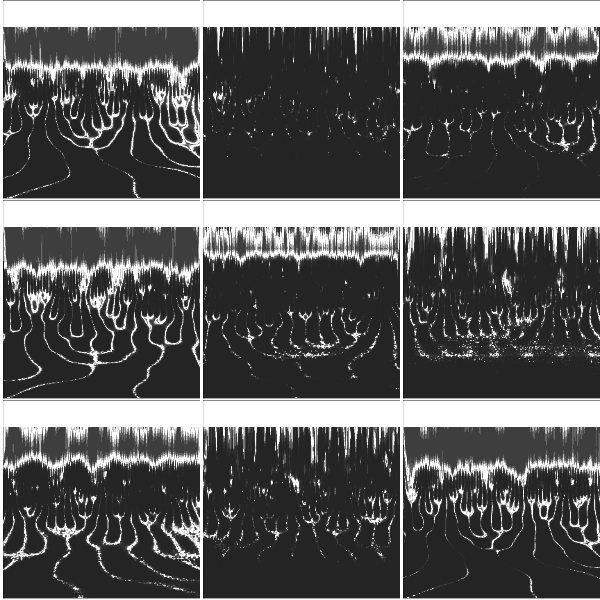

In [385]:
cv2_imshow(collaged_array)

NameError: ignored

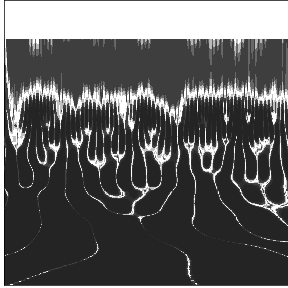

In [342]:
cv2_imshow(greyscale_array)

In [343]:
#cropping function:

(288, 288)

In [355]:
def crop_image(img,tol=255):
    # img is 2D image data
    # tol  is tolerance
    mask = img<tol
    return img[np.ix_(mask.any(1),mask.any(0))]

#cropped_image = crop_image(greyscale_array)

(286, 284)

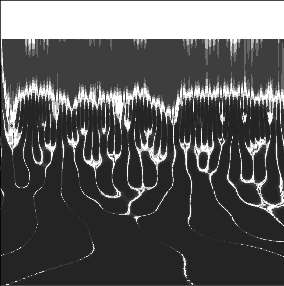

# Begin FastAI



In [4]:
# Move all the alc and control files into 
# one directory
#root_dir = #
#Alc_Dir has 235 images

#Con_Dir has 232 Images

Alc_Dir = '/content/drive/MyDrive/Colab_Data/DL201/EEG/Alc'
Con_Dir = '/content/drive/MyDrive/Colab_Data/DL201/EEG/Con'


EEG_Con_Path = Alc_Dir
EEG_Alc_Path = Con_Dir

List_EEG_Con = [os.path.join(EEG_Con_Path, f) for f in os.listdir(EEG_Con_Path)]
List_EEG_Alc = [os.path.join(EEG_Alc_Path, f) for f in os.listdir(EEG_Alc_Path)]

root_dir = '/content/drive/MyDrive/Colab_Data/DL201/EEG/'

In [5]:
NumOfControlImages = len(List_EEG_Con) 
NumOfAlchImages = len(List_EEG_Alc) 

print(f'Control Group size {NumOfControlImages}')
print(f'Alcholic Group size: {NumOfAlchImages}')

Control Group size 235
Alcholic Group size: 233


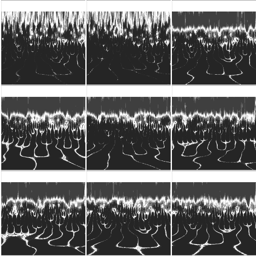

In [8]:
from PIL import Image
picked_image = 47
im = Image.open(List_EEG_Alc[picked_image])
im.to_thumb(256,256)

In [9]:
class DataLoaders(GetAttr):
  def __init__(self, *loaders): self.loaders = loaders
  def __getitem__(self, i): return self.loaders[i]
  train,valid = add_props(lambda i, self: self[i])

In [10]:
EEGs = DataBlock (
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter = RandomSplitter(valid_pct=0.2, seed=99),
    get_y=parent_label,
    #item_tfms=Resize(32,32)
    )

In [11]:
EEGs = EEGs.new(
    #item_tfms=RandomResizedCrop(28, min_scale=0.5),
    #batch_tfms=aug_transforms()
)
dls = EEGs.dataloaders(root_dir)

In [15]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(6)

epoch,train_loss,valid_loss,error_rate,time
0,1.162115,0.796615,0.451613,00:06


epoch,train_loss,valid_loss,error_rate,time
0,0.776918,0.806690,0.483871,00:07
1,0.613606,0.713642,0.387097,00:07
2,0.449639,0.624549,0.279570,00:07
3,0.339977,0.680605,0.301075,00:07
4,0.280833,0.710589,0.290323,00:07
5,0.233136,0.741712,0.290323,00:07


In [17]:
del learn

In [12]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(6)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


epoch,train_loss,valid_loss,error_rate,time
0,1.471548,2.431687,0.430108,01:42


epoch,train_loss,valid_loss,error_rate,time
0,0.840954,2.239835,0.430108,02:00
1,0.567864,2.256172,0.419355,01:56
2,0.420556,2.214324,0.419355,02:00
3,0.332535,2.138893,0.419355,01:56
4,0.268977,2.103091,0.397849,01:58
5,0.221991,1.831618,0.387097,02:00


In [14]:
learn.save('/content/drive/MyDrive/Colab_Data/DL201/eegResnet34.mdl')

Path('/content/drive/MyDrive/Colab_Data/DL201/eegResnet34.mdl.pth')